<a href="https://colab.research.google.com/github/anspire/Notebooks/blob/master/yolov3_tiny_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow-gpu==2.1.0

In [0]:
import os
os.kill(os.getpid(), 9)

In [1]:
from google.colab import drive
from absl import logging
import time
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    LeakyReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (
    binary_crossentropy,
    sparse_categorical_crossentropy
)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

print(tf.__version__)
print(tf.__git_version__)

2.1.0
v2.1.0-rc2-17-ge5bf8de


In [0]:
class BatchNormalization(tf.keras.layers.BatchNormalization):
    """
    Make trainable=False freeze BN for real (the og version is sad)
    """

    def call(self, x, training=False):
        if training is None:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

In [0]:
yolo_tiny_anchors = np.array([(10, 14), (23, 27), (37, 58),
                              (81, 82), (135, 169),  (344, 319)],
                             np.float32) / 416
yolo_tiny_anchor_masks = np.array([[3, 4, 5], [0, 1, 2]])

yolo_max_boxes = 100
yolo_iou_threshold = 0.5
yolo_score_threshold = 0.5

def DarknetConv(x, filters, size, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=size,
               strides=strides, padding=padding,
               use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x

def DarknetTiny(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 16, 3)
    x = MaxPool2D(2, 2, 'same')(x)
    x = DarknetConv(x, 32, 3)
    x = MaxPool2D(2, 2, 'same')(x)
    x = DarknetConv(x, 64, 3)
    x = MaxPool2D(2, 2, 'same')(x)
    x = DarknetConv(x, 128, 3)
    x = MaxPool2D(2, 2, 'same')(x)
    x = x_8 = DarknetConv(x, 256, 3)  # skip connection
    x = MaxPool2D(2, 2, 'same')(x)
    x = DarknetConv(x, 512, 3)
    x = MaxPool2D(2, 1, 'same')(x)
    x = DarknetConv(x, 1024, 3)
    return tf.keras.Model(inputs, (x_8, x), name=name)

def YoloConvTiny(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])
            x = DarknetConv(x, filters, 1)

        return Model(inputs, x, name=name)(x_in)
    return yolo_conv

def YoloOutput(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                            anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output

def yolo_boxes(pred, anchors, classes):
    # pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))
    grid_size = tf.shape(pred)[1]
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)

    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss

    # !!! grid[x][y] == (y, x)
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]

    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)

    return bbox, objectness, class_probs, pred_box


def yolo_nms(outputs, anchors, masks, classes):
    # boxes, conf, type
    b, c, t = [], [], []

    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))

    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)

    scores = confidence * class_probs
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=yolo_max_boxes,
        max_total_size=yolo_max_boxes,
        iou_threshold=yolo_iou_threshold,
        score_threshold=yolo_score_threshold
    )

    return boxes, scores, classes, valid_detections

def YoloV3Tiny(size=None, channels=3, anchors=yolo_tiny_anchors,
               masks=yolo_tiny_anchor_masks, classes=80, training=False):
    x = inputs = Input([size, size, channels], name='input')

    x_8, x = DarknetTiny(name='yolo_darknet')(x)

    x = YoloConvTiny(256, name='yolo_conv_0')(x)
    output_0 = YoloOutput(256, len(masks[0]), classes, name='yolo_output_0')(x)

    x = YoloConvTiny(128, name='yolo_conv_1')((x, x_8))
    output_1 = YoloOutput(128, len(masks[1]), classes, name='yolo_output_1')(x)

    if training:
        return Model(inputs, (output_0, output_1), name='yolov3')

    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                     name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                     name='yolo_boxes_1')(output_1)
    outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, classes),
                     name='yolo_nms')((boxes_0[:3], boxes_1[:3]))
    return Model(inputs, outputs, name='yolov3_tiny')


In [0]:
YOLOV3_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
    'yolo_conv_2',
    'yolo_output_2',
]

YOLOV3_TINY_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
]

def load_darknet_weights(model, weights_file, tiny=False):
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

    if tiny:
        layers = YOLOV3_TINY_LAYER_LIST
    else:
        layers = YOLOV3_LAYER_LIST

    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and \
                    sub_model.layers[i + 1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i + 1]

            print("{}/{} {}".format(
                sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))

            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.input_shape[-1]

            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                # darknet [beta, gamma, mean, variance]
                bn_weights = np.fromfile(
                    wf, dtype=np.float32, count=4 * filters)
                # tf [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

            # darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(
                wf, dtype=np.float32, count=np.product(conv_shape))
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])

            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)

    assert len(wf.read()) == 0, 'failed to read all data'
    wf.close()

def draw_outputs(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img


def draw_labels(x, y, class_names):
    img = x.numpy()
    boxes, classes = tf.split(y, (4, 1), axis=-1)
    classes = classes[..., 0]
    wh = np.flip(img.shape[0:2])
    for i in range(len(boxes)):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, class_names[classes[i]],
                          x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL,
                          1, (0, 0, 255), 2)
    return img



In [5]:
num_classes = 80
yolo = YoloV3Tiny(classes=num_classes)
yolo.summary()

Model: "yolov3_tiny"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
yolo_darknet (Model)            ((None, None, None,  6298480     input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Model)             (None, None, None, 2 263168      yolo_darknet[1][1]               
__________________________________________________________________________________________________
yolo_conv_1 (Model)             (None, None, None, 3 33280       yolo_conv_0[1][0]                
                                                                 yolo_darknet[1][0]     

In [6]:
!wget https://pjreddie.com/media/files/yolov3-tiny.weights

--2020-03-05 09:51:54--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘yolov3-tiny.weights’

yolov3-tiny.weights 100%[===================>]  33.79M  84.3KB/s    in 9m 47s  

2020-03-05 10:01:43 (59.0 KB/s) - ‘yolov3-tiny.weights’ saved [35434956/35434956]



In [7]:
weights = 'yolov3-tiny.weights'
output_weights = 'yolo-tiny.h5'
load_darknet_weights(yolo, weights, True)
yolo.save_weights(output_weights)

yolo_darknet/conv2d bn
yolo_darknet/conv2d_1 bn
yolo_darknet/conv2d_2 bn
yolo_darknet/conv2d_3 bn
yolo_darknet/conv2d_4 bn
yolo_darknet/conv2d_5 bn
yolo_darknet/conv2d_6 bn
yolo_conv_0/conv2d_7 bn
yolo_output_0/conv2d_8 bn
yolo_output_0/conv2d_9 bias
yolo_conv_1/conv2d_10 bn
yolo_output_1/conv2d_11 bn
yolo_output_1/conv2d_12 bias


In [8]:
num_classes = 80
weights = 'yolo-tiny.h5'
classes = 'coco.names'
size = 416

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

yolo = YoloV3Tiny(classes = num_classes, size = size)
print('model created')

yolo.summary()

yolo.load_weights(weights)
print('weights loaded')

class_names = [c.strip() for c in open(classes).readlines()]
print('classes loaded')

model created
Model: "yolov3_tiny"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
yolo_darknet (Model)            multiple             6298480     input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Model)             (None, 13, 13, 256)  263168      yolo_darknet[1][1]               
__________________________________________________________________________________________________
yolo_conv_1 (Model)             (None, 26, 26, 384)  33280       yolo_conv_0[1][0]                
                                                                 yolo_dark

In [0]:
def transform_images(x_train, size):
    x_train = tf.image.resize(x_train, (size, size))
    x_train = x_train / 255
    return x_train

time: 0.2466268539428711
detections:
	car, 0.9157130122184753, [0.29890415 0.38086182 0.36064854 0.5202759 ]
	bus, 0.90668785572052, [0.36375192 0.15101331 0.62805057 0.50172883]
	bus, 0.674160361289978, [0.671885   0.19172342 0.97814786 0.54268146]
	car, 0.6165611147880554, [0.2463859  0.35268342 0.39559373 0.5378101 ]
	person, 0.5871637463569641, [0.24246435 0.40669447 0.27136987 0.48467493]
output saved to: output.jpg


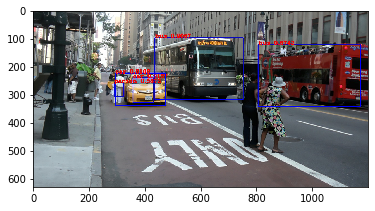

In [11]:
image = 'street.jpg'
size = 416
output_img = 'output.jpg'

img_raw = tf.image.decode_image(open(image, 'rb').read(), channels=3)
img = tf.expand_dims(img_raw, 0)
img = transform_images(img, size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
print('time: {}'.format(t2 - t1))

print('detections:')
for i in range(nums[0]):
    print('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                           np.array(scores[0][i]),
                                           np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
cv2.imwrite(output_img, img)
print('output saved to: {}'.format(output_img))
img=mpimg.imread(output_img)
plt.imshow(img)
plt.show()

In [12]:
converter = tf.lite.TFLiteConverter.from_keras_model(yolo)
converter.allow_custom_ops = True
converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

35426432

In [13]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
#interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
print(input_shape)
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
print(input_data.shape)

interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
tflite_results = interpreter.get_tensor(output_details[0]['index'])

# Test the TensorFlow model on random input data.
tf_results = model(tf.constant(input_data))

# Compare the result.
for tf_result, tflite_result in zip(tf_results, tflite_results):
   np.testing.assert_almost_equal(tf_result, tflite_result, decimal=5)


[{'name': 'input', 'index': 8, 'shape': array([  1, 416, 416,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]
[{'name': 'Identity', 'index': 4, 'shape': array([], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}, {'name': 'Identity_1', 'index': 5, 'shape': array([], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}, {'name': 'Identity_2', 'index': 6, 'shape': array([], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}, {'name': 'Identity_3', 'index': 7, 'shape': array([], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]
[  1 416 416   3]
(1, 416, 416, 3)


RuntimeError: ignored